<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/lunar_lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lunar Lander

In [1]:
!pip install -qq Box2D

     |████████████████████████████████| 1.3 MB 33.7 MB/s 


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

from multiprocessing import Pool, cpu_count

from tqdm.notebook import tqdm

## Visualization

In [3]:
def do_all_plots(ep_lengths, ep_rewards, title = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    if title: fig.suptitle(title)
    ax1.plot(ep_lengths, color='C0')
    ax1.set_xlabel('episode (#)')
    ax1.set_ylabel('steps (#)')
    ax1.set_title('episode length')
    ax2.plot(ep_rewards, color='C1')
    ax2.set_xlabel('episode (#)')
    ax2.set_ylabel('reward (#)')
    ax2.set_title('episode total reward')

## RBF function approximation

In [4]:
def Q_learning_with_rbf_linapprox(env, gamma = 0.99, episodes = 5000):
    obs_space, act_space = env.observation_space.shape, env.action_space.n

    # create random observations
    obs_samples = np.stack([env.observation_space.sample() for x in range(5000)])

    # fit a scaler (removes mean and std)
    scaler = StandardScaler()
    scaler.fit(obs_samples)

    # fit a rbf feature mapper
    gammas = [5, 2, 1, 0.5] 
    rbf_mapper = FeatureUnion([(f'rbf{i}', RBFSampler(gamma=g)) for i, g in enumerate(gammas)])
    rbf_mapper.fit(obs_samples)

    # preprocess from env state to new features
    preprocess = lambda s: rbf_mapper.transform(scaler.transform(s.reshape(1, -1)))

    # create a Q linear SGD function for each action
    Q_fncs = []
    for a in range(act_space):
        mdl = SGDRegressor(learning_rate='constant')
        mdl.partial_fit(preprocess(np.zeros(obs_space)), [0])
        Q_fncs.append(mdl)

    # compute Q(s, a) or Q(s, :)
    get_Q = lambda s, a: Q_fncs[a].predict(preprocess(s))
    get_Qs = lambda s: np.asarray([Q_fncs[a].predict(preprocess(s)) for a in range(act_space)])
    
    # perform an SGD update step for Q(s, a)
    update_Q = lambda s, a, target: Q_fncs[a].partial_fit(preprocess(s), [target]) 

    # get best action with exploration
    glie_policy = lambda s, eps: get_Qs(s).argmax() if np.random.rand() > eps else env.action_space.sample()

    # training loop
    ep_lengths, smoothed_lengths = [], []
    tot_rewards, smoothed_rewards = [], []
    for ep in tqdm(range(episodes)):
        # reset env and compute epsilon for this episode
        epsilon = 0.9 * 0.997**ep
        steps, tot_reward = 0, 0
        state, done = env.reset(), False

        # simulate episode
        while not done:
            action = glie_policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)        
            target = reward + gamma * get_Qs(next_state).max()
            update_Q(state, action, target)
            tot_reward += reward
            state = next_state
            steps += 1
            if steps > 300: break # if it gets stuck

        # save episode info
        ep_lengths.append(steps)
        smoothed_lengths.append(np.mean(ep_lengths[min(0, ep - 200):]))
        tot_rewards.append(tot_reward)
        smoothed_rewards.append(np.mean(tot_rewards[min(0, ep - 200):]))
        if ep % (episodes // 10) == 0:
            print(f'episode {ep}: mean steps = {smoothed_lengths[-1]:.2f}, total mean reward = {smoothed_rewards[-1]:.2f}')

    return get_Q, smoothed_lengths, smoothed_rewards

  0%|          | 0/5000 [00:00<?, ?it/s]

episode 0: mean steps = 145.00, total mean reward = -152.49
episode 500: mean steps = 187.02, total mean reward = -62.90
episode 1000: mean steps = 235.36, total mean reward = -23.06
episode 1500: mean steps = 255.63, total mean reward = -3.44
episode 2000: mean steps = 266.46, total mean reward = 6.62
episode 2500: mean steps = 271.98, total mean reward = 9.88
episode 3000: mean steps = 276.13, total mean reward = 13.09
episode 3500: mean steps = 279.51, total mean reward = 15.94
episode 4000: mean steps = 282.15, total mean reward = 18.22
episode 4500: mean steps = 284.24, total mean reward = 20.60


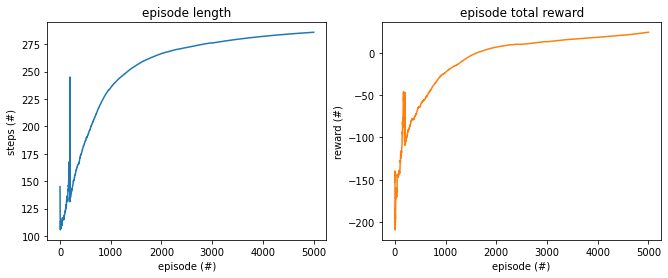

In [5]:
env = gym.make('LunarLander-v2')
get_Q, ep_lengths, ep_total_rewards = Q_learning_with_rbf_linapprox(env, episodes=5000)
do_all_plots(ep_lengths, ep_total_rewards)

## Testing

In [6]:
def Qs2deterministic(Q):
    return lambda s: np.argmax(Q(s, a) for a in range(env.action_space.n))

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / exp_x.sum()

def Qs2softmax(Q):
    actions = np.arange(env.action_space.n)
    return lambda s: np.random.choice(actions, p=softmax([Q(s, a) for a in actions]).ravel())

def test(original_env, policy, episodes = 10, render=False):
    if render:
        !apt -qq install xvfb
        !pip install -qq gym-notebook-wrapper
        import gnwrapper
    
    ep_lengths = []
    ep_total_rewards = []
    
    # run episodes
    for ep in tqdm(range(episodes)):
        env = gnwrapper.Monitor(original_env) if render else original_env

        # run till done
        steps, tot_reward, done = 0, 0, False
        state = env.reset()
        while not done:
            action = policy(state)
            state, reward, done, _ = env.step(action)
            steps += 1
            tot_reward += reward

        # append results
        ep_lengths.append(steps)
        ep_total_rewards.append(tot_reward)

        # show episode
        print(f'episode {ep}: steps = {steps}, total reward = {tot_reward:.3f}')
        if render:
            env.display()
    return ep_lengths, ep_total_rewards

  0%|          | 0/10 [00:00<?, ?it/s]

episode 0: steps = 1000, total reward = 44.618
episode 1: steps = 1000, total reward = -17.095
episode 2: steps = 1000, total reward = -16.959
episode 3: steps = 1000, total reward = -5.499
episode 4: steps = 691, total reward = -438.630
episode 5: steps = 1000, total reward = 7.207
episode 6: steps = 1000, total reward = 33.321
episode 7: steps = 1000, total reward = -64.294
episode 8: steps = 1000, total reward = 9.131
episode 9: steps = 1000, total reward = 23.300


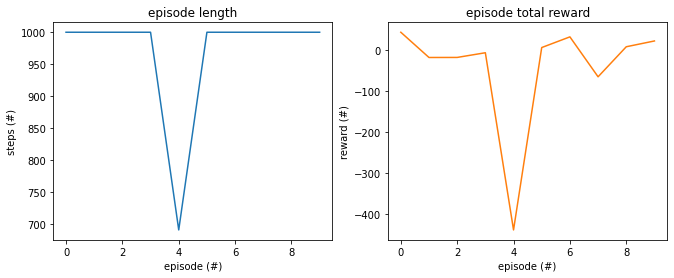

In [7]:
# !rm -rf 202*/

env = gym.make('LunarLander-v2')
ep_lengths, ep_total_rewards = test(env, Qs2softmax(get_Q), episodes=10, render=False)
do_all_plots(ep_lengths, ep_total_rewards)